# Tutorial on how to train a classifier on CIFAR10 dataset

- Dataflow
    - Extending dataflow on a custom dataset
- Data augmentation
- Training
- Inference
- Predictions quality

References:
- [pytorch-tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#sphx-glr-beginner-transfer-learning-tutorial-py)
- [data loading tutorial](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html)

In [1]:
import os 
import torch
import torchvision

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

In [5]:
os.environ['CIFAR10_ROOT'] = '/media/user/fast_storage/tensorpack_data/cifar10_data/'

In [6]:
CIFAR10_ROOT = os.environ['CIFAR10_ROOT']

## Dataflow

Purpose of dataflow is to provide data samples :
- in a random order
- with data augmentation
    - X as image
        - geometric
        - color
    - Y as image
        - geometric (synchronized with X)
- type and range conversions : `uint8 -> float32`, `[0, 255] -> [min, max]`
- in batches
- as torch tensors
    - on CPU
    - on GPU

In [7]:
train_ds = torchvision.datasets.CIFAR10(root=CIFAR10_ROOT, train=True, download=False)
test_ds = torchvision.datasets.CIFAR10(root=CIFAR10_ROOT, train=False, download=False)

Train and test datasets instances implements methods:
- `__getitem__` to get data sample `(x, y)` at index
- `__len__` to get the total number of samples

In [8]:
len(train_ds), len(test_ds)

(50000, 10000)

In [11]:
train_dp = train_ds[100]
test_dp = test_ds[100]
type(train_dp), type(train_dp[0]), type(train_dp[1])

(tuple, PIL.Image.Image, int)

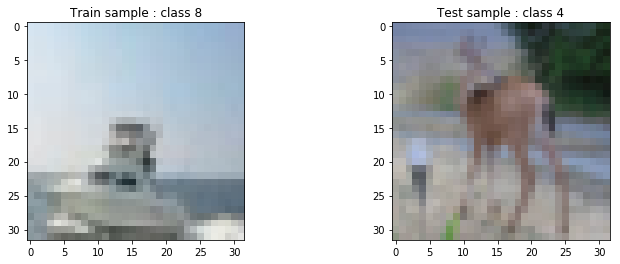

In [9]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.imshow(train_dp[0])
plt.title("Train sample : class %i" % train_dp[1])
plt.subplot(122)
plt.imshow(test_dp[0])
_ = plt.title("Test sample : class %i" % test_dp[1])

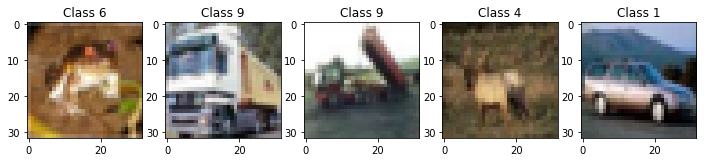

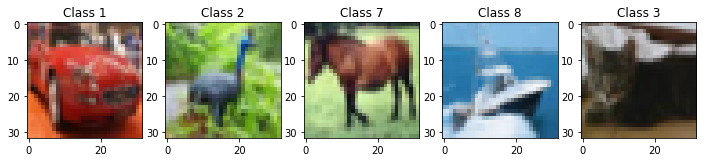

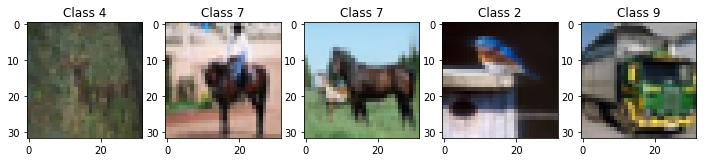

In [17]:
max_count = 15
n = 5
for i, (x, y) in enumerate(train_ds):
    
    if i % n == 0:
        plt.figure(figsize=(12, 4))
    
    plt.subplot(1, n, (i % n) + 1)
    plt.imshow(x)
    plt.title("Class %i" % y)
    
    max_count -= 1 
    if max_count == 0:
        break

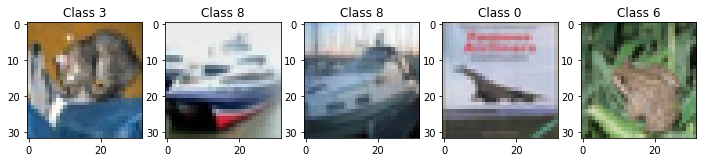

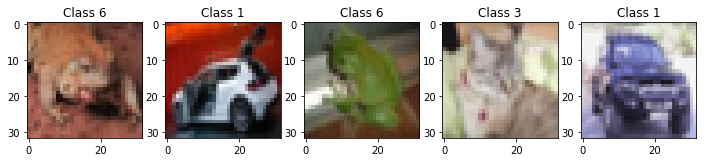

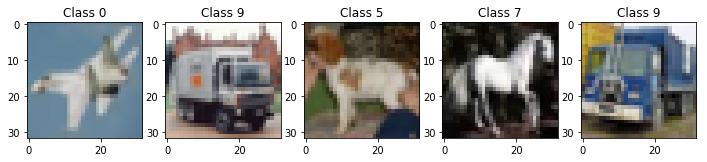

In [18]:
max_count = 15
n = 5
for i, (x, y) in enumerate(test_ds):
    
    if i % n == 0:
        plt.figure(figsize=(12, 4))
    
    plt.subplot(1, n, (i % n) + 1)
    plt.imshow(x)
    plt.title("Class %i" % y)
    
    max_count -= 1 
    if max_count == 0:
        break

Let's create a proxy dataset class to show an example of how to extend Dataset class on another data source. 

We have to simply reimplement two methods:
- `__len__`
- `__getitem__`

Let's suppose we need to work with CIFAR images of size 48 x 48. By default, torchvision CIFAR10 dataset returns a sample as a tuple of `PIL.Image.Image` and `int`. The following dataset returns samples as tuples of (`np.array`, `int`)

In [20]:
import cv2

class ResizeDataset:
    
    def __init__(self, ds, output_size=(32, 32)):
        self.ds = ds
        self.output_size = output_size
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, index):
        x, y = self.ds[index]
        img = np.asarray(x)
        img = cv2.resize(img, dsize=self.output_size[::-1])
        return img, y

In [21]:
resized_ds = ResizeDataset(train_ds, output_size=(48, 48))

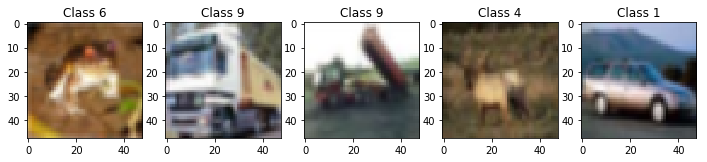

In [23]:
max_count = 5
n = 5
for i, (x, y) in enumerate(resized_ds):
    
    if i % n == 0:
        plt.figure(figsize=(12, 4))
    
    plt.subplot(1, n, (i % n) + 1)
    plt.imshow(x)
    plt.title("Class %i" % y)
    
    max_count -= 1 
    if max_count == 0:
        break

In a lot of examples of custom Dataset (even in `torchvision.datasets.CIFAR10`) data augmentation is incorporated in the dataset as callable object:
```
train_ds = torchvision.datasets.CIFAR10(root, train, transform=x_transform, target_transform=y_transform)

def __getitem__(self, index):
    ...
    if self.transform is not None:
            img = self.transform(img)
    ...
    if self.target_transform is not None:
        target = self.target_transform(target)

    return img, target
```

In [10]:
torchvision.datasets.CIFAR10.__getitem__??